## Two state variables
### Consumption-Based Model – Time-Varying Drift and Diffusion
Here the setup is more complicated, having two state variables. Both consumption drift and diffusion are simultaneously time-varying. The modified processes that will give the price of the zero coupon security are the following (where $\bar{x}_1$ and $\bar{x}_2$ revert to $X_1$ and $X_2$ respectively):

$$
\mathrm{d}c_{t}=\mu_{ct}\mathrm{d}t+\sigma_{ct}(1-|\rho_{c1}|-|\rho_{c2}|)\mathrm{d}W_{ct} +\sigma_{ct}\rho_{cx1}\mathrm{d}W_{x1t}+\sigma_{ct}\rho_{cx1}\mathrm{d}W_{x2t}\\
\mathrm{d}\bar{x}_{1t}=\big(-\log\phi\cdot(X_{1}-\bar{x}_{1t}) +\rho_{cx1}\sigma_{ct}\sigma_{1x}\big)\mathrm{d}t+\sigma_{x1}\frac{1}{1+\rho_{12}}\mathrm{d}W_{x1t} +\sigma_{x1}\frac{\rho_{12}}{1+\rho_{12}}\mathrm{d}W_{x2t}\\
\mathrm{d}\bar{x}_{2t}=\big(-\log\phi\cdot(X_{2}-\bar{x}_{2t}) +\rho_{cx2}\sigma_{ct}\sigma_{x2}\big)\mathrm{d}t+\sigma_{x2}\frac{\rho_{21}}{1+\rho_{21}}\mathrm{d}W_{x1t} +\sigma_{x2}\frac{1}{1+\rho_{21}}\mathrm{d}W_{x2t}
$$

where $W_{c1}$, $W_{x1}$ and $W_{x2}$ are independent and:
$$\mathrm{E}[\mathrm{d}c_{t}\mathrm{d}\bar{x}_{1t}]=\bigg(\rho_{cx1}\frac{1}{1+\rho_{12}}+\rho_{cx2}\frac{\rho_{12}}{1+\rho_{12}}\bigg)\sigma_{ct}\sigma_{x1}\mathrm{d}t\approxeq \rho_{cx1}\sigma_{ct}\sigma_{x1}\mathrm{d}t $$
$$\mathrm{E}[\mathrm{d}c_{t}\mathrm{d}\bar{x}_{2t}]=\bigg(\rho_{cx2}\frac{1}{1+\rho_{21}}+\rho_{cx1}\frac{\rho_{21}}{1+\rho_{21}}\bigg)\sigma_{ct}\sigma_{x2}\mathrm{d}t\approxeq \rho_{cx2}\sigma_{ct}\sigma_{x2}\mathrm{d}t $$
$$\mathrm{E}[\mathrm{d}\bar{x}_{1t}\mathrm{d}\bar{x}_{2t}]=\sigma_{x1}\sigma_{x2}\frac{\rho_{21}+\rho_{12}}{1+\rho_{12}+\rho_{21}+\rho_{12}\rho_{21}}\mathrm{d} t\approxeq (\rho_{12}+\rho_{21})\sigma_{x1}\sigma_{x2}\mathrm{d}t$$


and the approximate equations are valid if $\rho_{12}$ and $\rho_{21}$ are small.

In order to get the price of the zero-coupon security a process for the integral of the short-term rate will also be needed:

$$
\mathrm{d}A = r(\tilde{x}_t)\mathrm{d}t
$$

##### Import the packages

In [24]:
import SDFFinance as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

#### Define the parameters

In [25]:
cs = (
    phi1 = 0.92, # mean reversion
    phi2 = 0.92, # mean reversion
    rho = 0.02, # time preference parameter
    gamma = 2.0, # risk aversion
    muc = 0.005, # mean of consumption drift
    sigmac = 0.05, # mean of consumption diffusion
    X1 = 0.0, # long-run mean
    X2 = 0.0, # long-run mean
    sigmax1 = 0.01, # volatility
    sigmax2 = 0.3, # volatility
    rhocx1 = 0.3, # correlation
    rhocx2 = -0.3, # correlation
    rho12 = 0.1, # correlation
    rho21 = 0.1 # correlation
    );

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [26]:
###- now consumption diffusion is a non-linear function of the state, 
###- given that it needs to be positive.
###- I use this function because the simple exponential can get too high for some samples.
sigmac(x,c) = c.sigmac*(x<0 ? 2/(1+exp(-2x)) : 4/(1+exp(-x))-1);
muc(x,c) = c.muc + x;
sigmac(x) = sigmac(x,cs);
sigma1_1(x,c) = c.sigmax1/(1+c.rho12); 
sigma1_2(x,c) = c.sigmax1*c.rho12/(1+c.rho12); 
sigma1(x,c) = sigma1_1(x,c)+sigma1_2(x,c); # diffusion
sigma2_1(x,c) = c.sigmax2*c.rho21/(1+c.rho21); 
sigma2_2(x,c) = c.sigmax2/(1+c.rho21); 
sigma2(x,c) = sigma2_1(x,c)+sigma2_2(x,c); # diffusion
mu1(x,c) = -log(c.phi1)*(c.X1-x)-c.gamma*sigmac(x,c)*(sigma1_1(x,c)*c.rhocx1+sigma1_2(x,c)*c.rhocx2); # drift of modified state
mu2(x,c) = -log(c.phi2)*(c.X2-x)-c.gamma*sigmac(x,c)*(sigma2_1(x,c)*c.rhocx1+sigma2_2(x,c)*c.rhocx2); # drift of modified state
mu10(x,c) = -log(c.phi1)*(c.X1-x); # drift of unmodified state
mu20(x,c) = -log(c.phi2)*(c.X2-x); # drift of unmodified state


#### Short-term rate function

In [27]:
r(x1,x2,c) = c.rho+c.gamma*muc(x1,c)-c.gamma^2*sigmac(x2,c)^2/2;
r(x1,x2) = r(x1,x2,cs);

#### Define setup consistent with SDE solution in Julia

In [28]:
function drift(du,u,p,t,c)
    du[1] = mu1(u[1],c)
    du[2] = mu2(u[2],c)
    du[3] = mu10(u[3],c)
    du[4] = mu20(u[4],c)
    du[5] = r(u[1],u[2],c)
    du[6] = r(u[3],u[4],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1, 1] = sigma1_1(u[1], c)
    du[1, 2] = sigma1_2(u[1], c)
    du[2, 1] = sigma2_1(u[2], c)
    du[2, 2] = sigma2_2(u[2], c)
    du[3, 1] = sigma1_1(u[3], c)
    du[3, 2] = sigma1_2(u[3], c)
    du[4, 1] = sigma2_1(u[4], c)
    du[4, 2] = sigma2_2(u[4], c)
    du[5, 1] = 0.0
    du[5, 2] = 0.0
    du[6, 1] = 0.0
    du[6, 2] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In [29]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=2,outVariables=[5,6],
terminalFunction=(ik, x, y, z) -> exp(-x),diagonalNoise=false);
xRanges = [-0.05:0.01:0.05,-2.0:0.4:2.0];
tRange = 0.0:1.0:20.0;
sett = sdf.SolutionSettings(xRanges=xRanges, initialValues=vcat([[x, y,x,y, 0.0,0.0] for y in xRanges[2] for x in xRanges[1]]), 
algorithm=sde.LambaEM(), pathsPerInitialValue=15000, tRange=tRange);

#### Solve Problem and Define Yield

In [30]:
((bondPrice,riskNeutralPrice),) = sdf.solve(prob, sett);
yld(t,x1,x2) = -log(bondPrice(t,x1,x2))/t;
yldRiskNeutral(t,x1,x2) = -log(riskNeutralPrice(t,x1,x2))/t;

#### Plot the yield

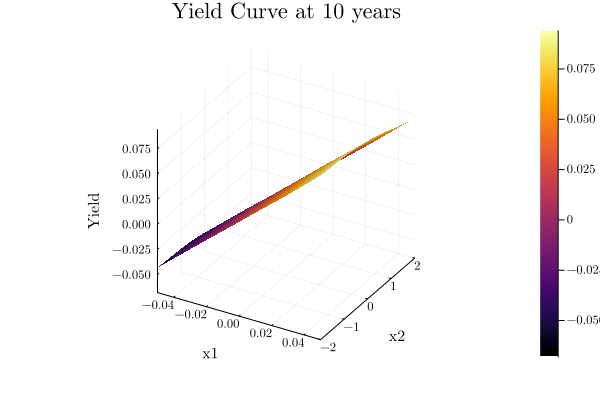

In [31]:
import Plots as plt
plt.gr()
plt.surface(xRanges[1],xRanges[2],(x,y)->yld(10.0,x,y),xlabel="x1",ylabel="x2",zlabel="Yield",title="Yield Curve at 10 years")

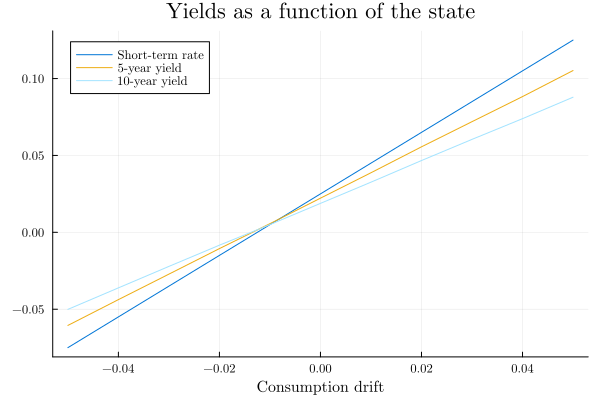

In [32]:
# colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000"
import Plots as plt
x2 = 0.0
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(xRanges[1], xRanges[1] .|> x1->r(x1,x2), title="Yields as a function of the state",
    xlabel="Consumption drift",label="Short-term rate",color="#0075d6")
plt.plot!(xRanges[1], yld.(5.0, xRanges[1],x2), label="5-year yield",color= "#edad14")
plt.plot!(xRanges[1], yld.(10.0, xRanges[1],x2), label="10-year yield",color="#a3e3ff")

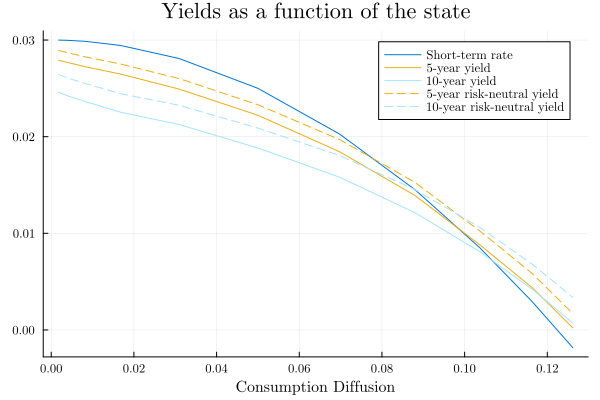

In [33]:
# colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000"
import Plots as plt
x1 = 0.0
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(sigmac.(xRanges[2]), xRanges[2] .|> x2->r(x1,x2), title="Yields as a function of the state",
    xlabel="Consumption Diffusion",label="Short-term rate",color="#0075d6")
plt.plot!(sigmac.(xRanges[2]), yld.(5.0, x1,xRanges[2]), label="5-year yield",color= "#edad14")
plt.plot!(sigmac.(xRanges[2]), yld.(10.0, x1,xRanges[2]), label="10-year yield",color="#a3e3ff")
plt.plot!(sigmac.(xRanges[2]), yldRiskNeutral.(5.0, x1,xRanges[2]), label="5-year risk-neutral yield",color= "#edad14",style=:dash)
plt.plot!(sigmac.(xRanges[2]), yldRiskNeutral.(10.0, x1,xRanges[2]), label="10-year risk-neutral yield",color="#a3e3ff",style=:dash)

In [40]:
using PlotlyJS
coordinates = surface(
    z=[yld(10.0, x1, x2) for x1 in xRanges[1], x2 in xRanges[2]], x=xRanges[1],
    y=sigmac.(xRanges[2]),
    showscale=false)

layout = Layout(
    width=800, height=600,
    title_x=0.5,
    titlefont_size="16",
    scene_aspectratio=attr(x=1, y=1, z=0.5),
    scene=attr(
        xaxis=attr(title="Cons. Drift"),
        yaxis=attr(title="Cons. Diffusion"),
        zaxis=attr(title="Yield"),
        camera=attr(
            eye=attr(x=1.25, y=1.25, z=1.25)
        )
    ),
    font=attr(family="Computer Modern", size=12, color="black"),
    margin=attr(l=0, r=50, b=100, t=100, pad=4))
plot([coordinates], layout)


data: [
  "surface with fields showscale, type, x, y, and z"
]

layout: "layout with fields font, height, margin, scene, template, title, titlefont, and width"